In [134]:
#John Carther V. Lao
# import libraries
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

#additional libraries
%matplotlib inline
from scipy import stats
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras import Sequential, layers, callbacks
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Set random seed to get the same result after each time running the code
tf.random.set_seed(1234)

<font size="5">***Machine Learning Step: Gathering Data***</font>

***Import dataset***

In [135]:
file = 'C:\\Users\\Carther\\Desktop\\COE_Q_2\\RRHI_Historical_Data.csv'
df = pd.read_csv(file, parse_dates = ['Date'], index_col = 'Date')
df = df.iloc[::-1]
df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-10-09,63.65,64.30,64.30,63.50,567.22K,-2.00%
2020-10-12,64.25,64.00,65.00,63.70,568.32K,0.94%
2020-10-13,66.30,65.00,67.00,65.00,263.78K,3.19%
2020-10-14,67.00,66.30,67.00,66.20,61.18K,1.06%
2020-10-15,67.25,66.80,67.25,65.30,112.96K,0.37%
...,...,...,...,...,...,...
2022-10-04,54.50,54.55,55.50,54.40,717.19K,0.09%
2022-10-05,55.50,55.50,56.45,54.60,373.36K,1.83%
2022-10-06,53.65,55.40,55.40,53.65,233.26K,-3.33%


<font size="5">***Machine Learning Step: Preparing Data***</font>

***Data Pre-processing***

In [154]:
# Split train data and test data
train_size = int(len(df)*0.8)

# use iloc to select a number of rows
train_data = df.iloc[:train_size,1:2].values
test_data = df.iloc[train_size:,1:2].values

In [137]:
# Scale data
scaler = MinMaxScaler().fit(train_data)

train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [138]:
# Create input dataset function
def create_dataset (X, look_back = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
        
    return np.array(Xs), np.array(ys)

# create x and y test and train
X_train, y_train = create_dataset(train_scaled,30)
X_test, y_test = create_dataset(test_scaled,30)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (363, 30, 1)
y_train.shape:  (363, 1)
X_test.shape:  (69, 30, 1)
y_test.shape:  (69, 1)


<font size="5">***Machine Learning Step: Choose Model - Gated Recurrent Unit***</font>

***Model Creation***

In [139]:
# Create GRU model
def create_gru(units):
    model = Sequential()
    
    # Input layer 
    model.add(GRU (units = units, return_sequences = True, 
                 input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2))
    
    # Hidden layer
    model.add(GRU(units = units, activation='tanh', recurrent_activation='sigmoid', stateful=False))            
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    
    #compile model
    model.compile(optimizer='adam', # default='rmsprop'
                  loss='mean_squared_error', # Loss function to be optimized
                  metrics=['MeanSquaredError', 'MeanAbsoluteError'],
                  loss_weights=None,
                  weighted_metrics=None,
                  run_eagerly=None,
                  steps_per_execution=None
                 )
   
    return model

***Model Summary***

In [140]:
#set model units
model_gru = create_gru(64)

#show model summary
model_gru.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 30, 64)            12864     
                                                                 
 dropout_6 (Dropout)         (None, 30, 64)            0         
                                                                 
 gru_7 (GRU)                 (None, 64)                24960     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 37,889
Trainable params: 37,889
Non-trainable params: 0
_________________________________________________________________


<font size="5">***Machine Learning Step: Train Model***</font>

***Model Fitting***

In [141]:
#create function to fit model
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, batch_size=5, epochs=100, verbose=1, callbacks= None, validation_split=0.2,
                        shuffle=False, class_weight=None,
                        sample_weight=None, #used for weighting the loss function during training only
                        initial_epoch=0, steps_per_epoch=None, validation_steps=None, validation_batch_size=None,
                        validation_freq=1, # check every epoch
                        max_queue_size=10, workers=1, use_multiprocessing=True,
                       )
    return history

In [142]:
#fit model
history_gru = fit_model(model_gru)

Epoch 1/100
58/58 [==============================] - 4s 30ms/step - loss: 0.0688 - mean_squared_error: 0.0688 - mean_absolute_error: 0.1746 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0946
Epoch 2/100
58/58 [==============================] - 1s 18ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0780 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0978
Epoch 3/100
58/58 [==============================] - 1s 22ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - mean_absolute_error: 0.0825 - val_loss: 0.0155 - val_mean_squared_error: 0.0155 - val_mean_absolute_error: 0.1100
Epoch 4/100
58/58 [==============================] - 1s 19ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0789 - val_loss: 0.0163 - val_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.1135
Epoch 5/100
58/58 [==============================] - 1s 19ms/step - loss: 0.0111 - mean_squared_

<font size="5">***Machine Learning Step: Evaluate Model***</font>

In [143]:
hist_df = pd.DataFrame(history_gru.history) 
mean_squared_error = hist_df.at[99,'val_mean_squared_error']
print(math.sqrt(mean_squared_error))

0.06051823492403204


<font size="3">***Model Root Mean Square Error: 0.0605***</font>

In [144]:
# Plot train loss and validation loss
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

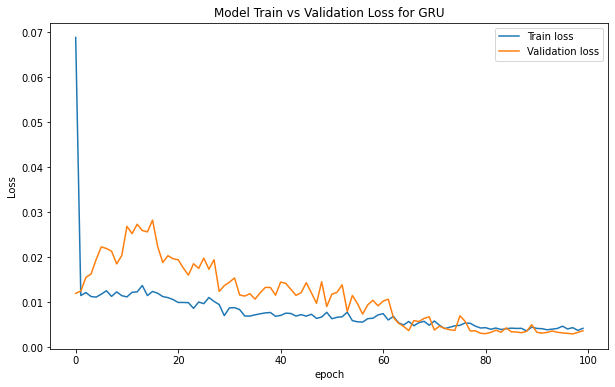

In [145]:
#show plot
plot_loss (history_gru, 'GRU')

<font size="5">***Machine Learning Step: Make Predictions***</font>

In [146]:
# Transform data back to original data space
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

In [147]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction

In [148]:
#start predictions
prediction_gru = prediction(model_gru)

3/3 [==============================] - 1s 8ms/step


In [149]:
# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='Test data')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('Price (Close)')

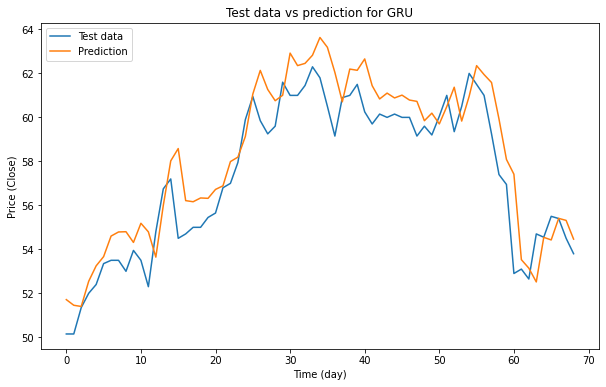

In [150]:
plot_future(prediction_gru, 'GRU', y_test)

In [151]:
# Calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')

In [152]:
evaluate_prediction(prediction_gru, y_test, 'GRU')

GRU:
Mean Absolute Error: 1.1958
Root Mean Square Error: 1.4857



<font size="5">***Making a 7-Day Forecast***</font>

In [232]:
# Select 60 days of data from test data
new_data = test_data[5:43]

# Scale the input
scaled_data = scaler.transform(new_data)

# Reshape the input 
def create_dataset (X, look_back = 120):
    Xs = []
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        
    return np.array(Xs)

In [233]:
X_30= create_dataset(scaled_data,30)
print('X_30.shape: ', X_30.shape) 

X_30.shape:  (8, 30, 1)


In [234]:
# Make prediction for new data
def prediction(model):
    prediction = model.predict(X_30)
    prediction = scaler.inverse_transform(prediction)
    return prediction

In [235]:
prediction_gru = prediction(model_gru)

1/1 [==============================] - 0s 21ms/step


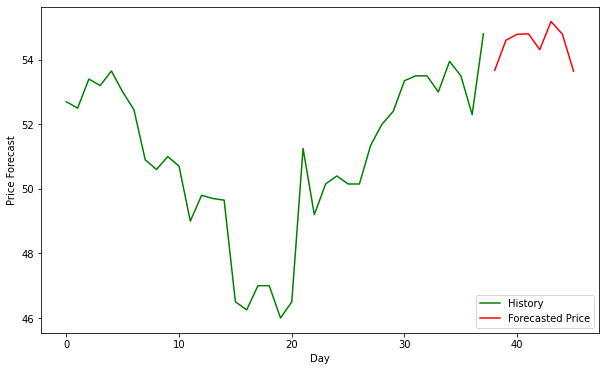

In [236]:
# Plot history and future
def plot_multi_step(history, prediction):
    plt.figure(figsize=(10, 6))
    
    global range_history, range_future
    range_history = len(history)
    range_future = list(range(range_history, range_history + len(prediction)))
    
    global data , a , b
    data=df.filter(['Price'])
    a=plt.plot(np.arange(range_history), np.array(history), color = 'green', label='History')
    b=plt.plot(range_future, np.array(prediction), color = 'red', label='Forecasted Price')
    plt.legend(loc='lower right')
    plt.xlabel('Day')
    plt.ylabel('Price Forecast')

plot_multi_step(new_data, prediction_gru)

In [240]:
prediction_gru

array([[53.667637],
       [54.602592],
       [54.788944],
       [54.800354],
       [54.31272 ],
       [55.184486],
       [54.794212],
       [53.64445 ]], dtype=float32)

In [246]:
prediction_test_out = pd.DataFrame(prediction_gru, columns=['Close']).to_csv("C:\\Users\\Carther\\Desktop\\COE_Q_2\\lao_outputs.csv")

In [ ]:
#John Carther V. Lao - 1911910